In [256]:
import pandas as pd
import textblob as tb
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud
%matplotlib inline

## Generating a Wordcloud image of all the review texts

In [10]:
data_path ="E:/Workspace/AI~ML~DP/xdi-amazon-eda-ml"
df = pd.read_csv(data_path + "/Data/Reviews.csv")
df = df.set_index("Id")

In [11]:
columns = list(df.columns)
# print(columns)
users = list(df["UserId"].unique()) # 25k+ users
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Creating a WordCloud image of the first 30,000 reviews

In [37]:
wordcloud_df = df["Text"]
words_dict = {}

for i in range(1, 30_000):
    curr_sent = wordcloud_df[i].split()
    for word in curr_sent:
        if word in words_dict:
            words_dict[word] += 1
        else:
            words_dict[word] = 1

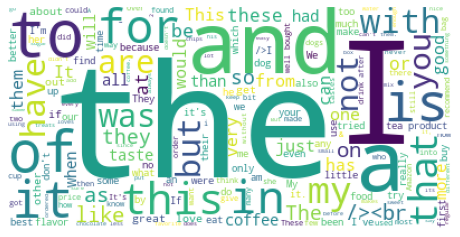

In [38]:
from wordcloud import STOPWORDS
import string
# not_needed = string.puntuation
cloud = WordCloud(background_color='white', stopwords = STOPWORDS)
cloud.generate_from_frequencies(words_dict)
img = cloud.to_array()
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.show()

## Visualizing the frequency of parts of speech of all top products and top reviews.

In [117]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,4,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,4,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,4,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,4,1350777600,Great taffy,Great taffy at a great price. There was a wid...


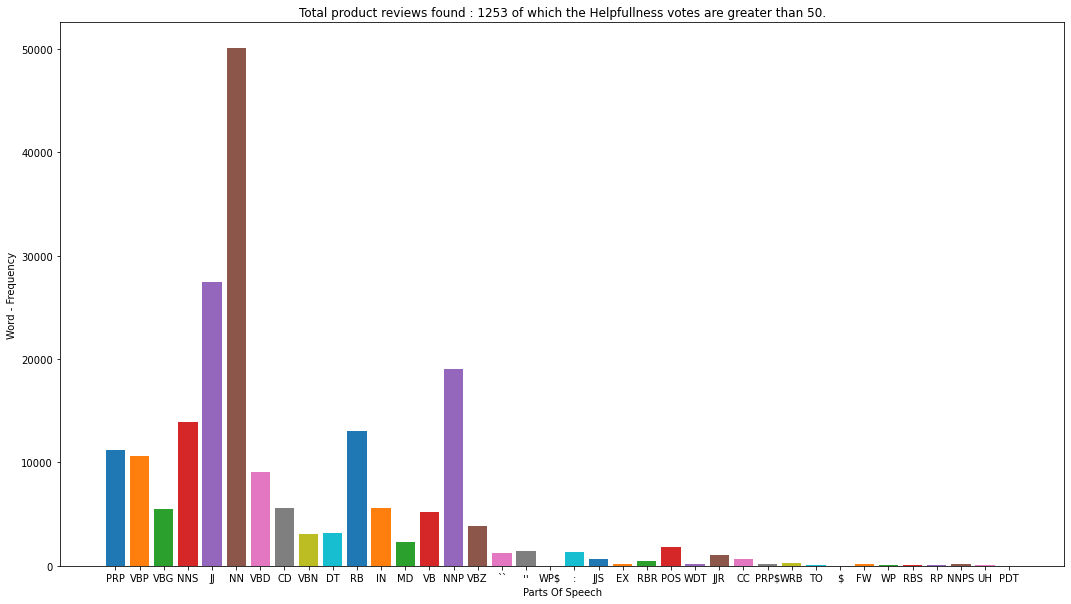

In [199]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter

stop_words = stopwords.words("english")
punc = punctuation

pos_dict = {}
w = Counter()

top_review_filter = df["HelpfulnessNumerator"] > 50

top_df = df.loc[top_review_filter, "Text"]

for i in range(len(top_df)):
    words = word_tokenize((top_df.iloc[i]))
    new = [w for w in words if w not in stop_words and w not in punc]
    # print(pos_tag(new))
    w.update((Counter([parts[1] for parts in pos_tag(new)])))

plt.rc('figure', figsize = (18,10))

for key, value in w.items():
    plt.bar(key, value)
# plt.bar(pos_dict.keys(),pos_dict.values())

plt.title(f"Total product reviews found : {top_df.shape[0]} of which the Helpfullness votes are greater than 50.")
plt.xlabel("Parts Of Speech")
plt.ylabel("Word - Frequency")
plt.show()

---
# Sentiment Analysis.
---

In [287]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

users_sentiment = {}

def clean_text(txt):
    stop_words = stopwords.words("english")
    tokenized = word_tokenize(txt)
    return ' '.join([w for w in tokenized if w not in stop_words and w not in punctuation])

def calc_sentiment():
    user_text_df = df[["UserId", "Text", "ProfileName"]]
    fltr = df["HelpfulnessNumerator"] > 50
    user_text_df = user_text_df.loc[fltr]
    for _, row in user_text_df.iterrows():
        userID, review, name = list(row)
        score = SentimentIntensityAnalyzer().polarity_scores(review)
#         print(score)
        if userID in users_sentiment.keys():
            users_sentiment[userID]['negative'] += score['neg']
            users_sentiment[userID]['neutral'] += score['neu']
            users_sentiment[userID]['positive'] += score['pos']
            users_sentiment[userID]['times'] += 1
        else:
#             print(score['neg'])
            users_sentiment[userID] = {
                'negative' : score['neg'],
                'neutral' : score['neu'],
                'positive' : score['pos'],
                'times' : 1,
                "name" : name
            }

    # divide the sentiments with the times values.
    pos, neg, neu = 0, 0, 0
    pos_name, neg_name, neu_name = "","",""
    for user_id, sent_dict in users_sentiment.items():
        for sentiment, value in sent_dict.items():
            if sentiment != "name":
                users_sentiment[user_id][sentiment] = round(users_sentiment[user_id][sentiment] / users_sentiment[user_id]["times"], 2)
                if sentiment == "positive" and users_sentiment[user_id][sentiment] > pos:
                    pos = users_sentiment[user_id][sentiment]
                    pos_name = users_sentiment[user_id]["name"]
                elif sentiment == "negative" and users_sentiment[user_id][sentiment] > neg:
                    neg = users_sentiment[user_id][sentiment]
                    neg_name = users_sentiment[user_id]["name"]
                elif sentiment == "neutral" and users_sentiment[user_id][sentiment] > neu:
                    neu = users_sentiment[user_id][sentiment]
                    neu_name = users_sentiment[user_id]["name"]
        del users_sentiment[user_id]["times"]
    
    # Printing the overall sentiment dominance of the top reviewers.
    print("Most positive reviews given by : {} with a rating of {}".format(pos_name, pos))
    print("Most negative reviews given by : {} with a rating of {}".format(neg_name, neg))
    print("Most neutral reviews given by : {} with a rating of {}".format(neu_name, neu))
    print()
    for user_id, sent_dict in users_sentiment.items():
        print( users_sentiment[user_id]["name"], " ---- ",user_id)
        for sentiment, value in sent_dict.items():
            if sentiment != "name":
                print("---->",sentiment.title(), " : ", value)
        print()

calc_sentiment()

Most positive reviews given by : Caroline M. Jones with a rating of 0.37
Most negative reviews given by : E. McCarthy with a rating of 0.36
Most neutral reviews given by : Ty with a rating of 1.0

MeMoi27  ----  A30G6Q3WKQ2ONS
----> Negative  :  0.08
----> Neutral  :  0.69
----> Positive  :  0.22

Shannon  ----  A2K5BNVW2P3F5L
----> Negative  :  0.11
----> Neutral  :  0.85
----> Positive  :  0.04

J. Newman "J. Newman"  ----  AO6735APC3YAJ
----> Negative  :  0.07
----> Neutral  :  0.81
----> Positive  :  0.12

Raven A. Wind  ----  A1J75JJ0Q2OEJN
----> Negative  :  0.08
----> Neutral  :  0.84
----> Positive  :  0.08

Thomas Viloria  ----  A17X8OG3YEZBDJ
----> Negative  :  0.04
----> Neutral  :  0.65
----> Positive  :  0.31

Stephanie L. Sanders  ----  A3SO3Q36EC3LJO
----> Negative  :  0.0
----> Neutral  :  0.89
----> Positive  :  0.11

R. Taylor "R. Taylor"  ----  A2MHH4FWA6B6FV
----> Negative  :  0.04
----> Neutral  :  0.82
----> Positive  :  0.15

Linda Freitag  ----  A2EZW502SEA2N9
-